# Benchmarking

In [1]:
from QPCA.decomposition.Qpca import QPCA
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import pickle 
from QPCA.preprocessingUtilities.preprocessing import generate_matrix
from QPCA.benchmark.benchmark import *

# Define input matrix and hyperparameters

Here we define a seed for the reproducibility of the experiments, the number of resolution qubits, the dimension of the input matrix, a specific eigenvalues list (if you want) and the number of measures that you are going to perform in the tomography algorithm to reconstruct the eigenvectors.

In [2]:
seed=7000
resolutions=[8]
matrix_dimension=4
eigenvalues_list=[0.65,0.25,0.06,0.04]
input_matrix=generate_matrix(matrix_dimension=matrix_dimension,replicate_paper=False,seed=seed,eigenvalues_list=eigenvalues_list)
shots_numbers=[1000000]

Matrix:
 [[0.37 0.18 0.12 0.12]
 [0.18 0.17 0.08 0.09]
 [0.12 0.08 0.13 0.15]
 [0.12 0.09 0.15 0.33]]

eigenvalue: 0.039999999999999994 - eigenvector: [ 0.043  0.284 -0.892  0.348]
eigenvalue: 0.060000000000000026 - eigenvector: [-0.5    0.833  0.182 -0.152]
eigenvalue: 0.25000000000000006 - eigenvector: [-0.564 -0.241  0.194  0.765]
eigenvalue: 0.6499999999999995 - eigenvector: [-0.656 -0.409 -0.364 -0.52 ]


# Eigenvectors reconstruction benchmark

In this first experiment, setting the eigenvector_benchmarking flag to True, you can visualize how the reconstructed eigenvectors corresponding to the reconstructed eigenvalues differ from the original ones with the specific resolution and number of shots that we provide before. If the results are not satisfied, you can try to increase the resolution or the number of shots (these things obviously increase the computational complexity). 


With "non-satisfying" results, we mean:
   - high reconstruction error
   - fewer eigenvalues (and therefore eigenvectors) reconstructed than the true number. See the [resolution_choices_example.ipynb](./resolution_choices_example.ipynb) notebook for major information on this.

Notice that for this experiment, the error_with_sign flag is set to True which means that the benchmark is done considering the reconstructed eigenvectors with reconstructed sign. If you want to benchmark only the absolute value of the eigenvectors, you can "turn off" this flag. Indeed, you can still observe the behavior of the reconstructed signs setting the sign_benchmarking to True, as shown in the next sections.



Resolution:  8




/opt/miniconda3/envs/EAGLE_environment/lib/python3.8/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/miniconda3/envs/EAGLE_environment/lib/python3.8/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


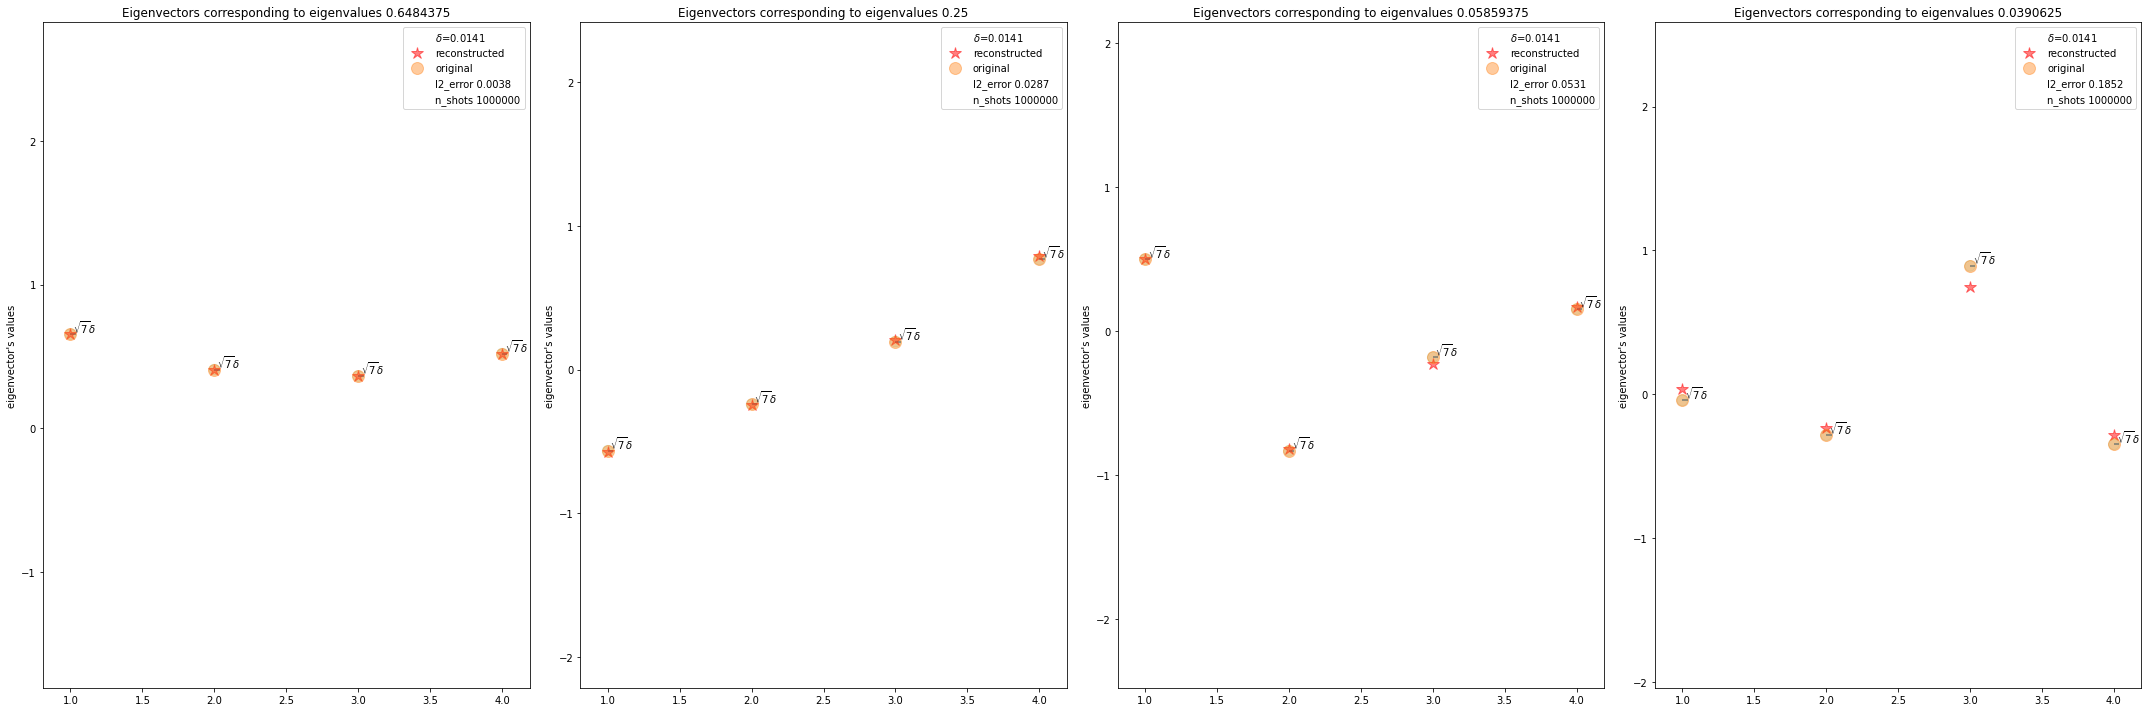

In [3]:
for resolution in resolutions:
    qpca=QPCA().fit(input_matrix,resolution=resolution)
    print('\n')
    print('\033[1m'+'Resolution: ',resolution)
    print('\n')
    for s in shots_numbers:
        reconstructed_eigenvalues,reconstructed_eigenvectors=qpca.eigenvectors_reconstruction(n_shots=s,n_repetitions=1)
        results=qpca.spectral_benchmarking(eigenvector_benchmarking=True,sign_benchmarking=False ,eigenvalues_benchmarching=False,print_distances=True,only_first_eigenvectors=False,
                                                        plot_delta=True,distance_type='l2',error_with_sign=True,hide_plot=False,print_error=False)
        #eig_evec_tuple,delta

# Eigenvectors reconstruction benchmark with sign table check

As said in the previous section, here we use the sign_benchmarking flag to print the sign table to view a summary of the reconstructed sign for every reconstructed eigenvalues. 

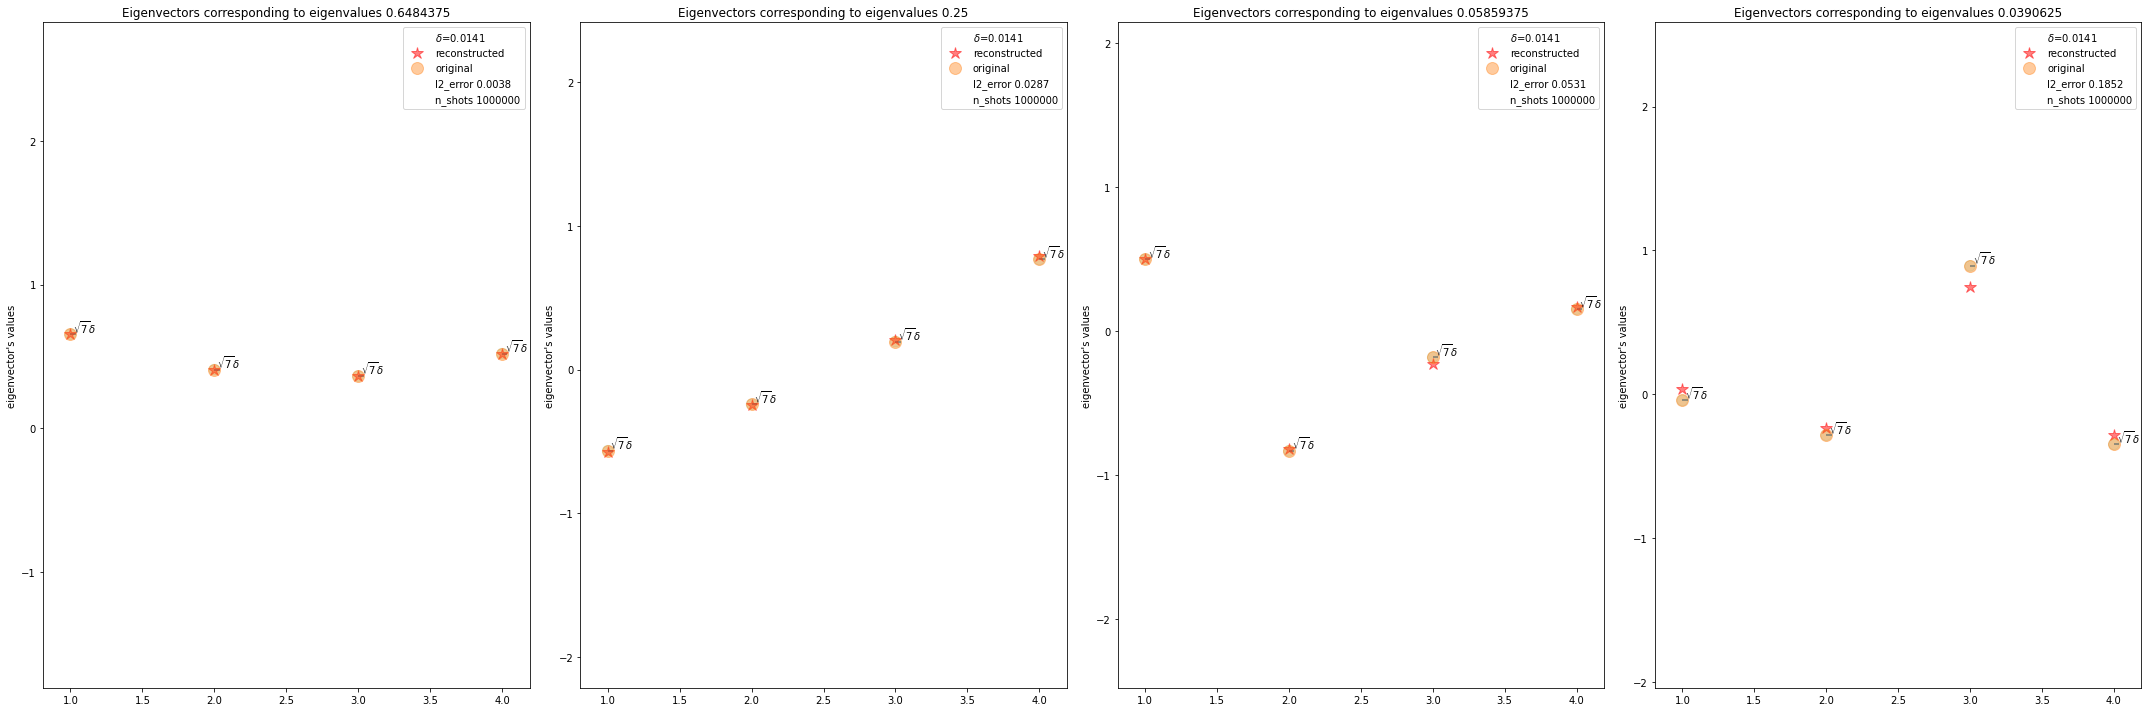

+------------+---------+--------------+------------+
| Eigenvalue | n_shots | correct_sign | wrong_sign |
+============+=========+==============+============+
| 0.650      | 1000000 | 4            | 0          |
+------------+---------+--------------+------------+
| 0.250      | 1000000 | 4            | 0          |
+------------+---------+--------------+------------+
| 0.060      | 1000000 | 4            | 0          |
+------------+---------+--------------+------------+
| 0.040      | 1000000 | 3            | 1          |
+------------+---------+--------------+------------+


In [4]:

results=qpca.spectral_benchmarking(eigenvector_benchmarking=True,sign_benchmarking=True ,eigenvalues_benchmarching=False,print_distances=True,only_first_eigenvectors=False,
                                                plot_delta=True,distance_type='l2',error_with_sign=True,hide_plot=False,print_error=False)

As we can see in this example, the table reports the correct and the wrong signs for each eigenvector corresponding to a specific eigenvalue (true eigenvalue).

Remember that if the original eigenvector is $$e_1=[-\alpha_1,\alpha_2,-\alpha_3,\alpha_4]$$

and we reconstruct an eigenvector such as $$\bar{e}_1=[\bar{\alpha}_1,-\bar{\alpha}_2,\bar{\alpha}_3,-\bar{\alpha}_4]$$
we consider correct all the reconstructed signs since it is like if we consider the original eigenvector multiplied by a factor of -1, and multiplying an eigenvector for a constant value doesn't change the information that it brings.

# Eigenvalues reconstruction benchmark

This experiment is related to the eigenvalues reconstruction. More precisely, setting the eigenvalues_benchmarching flag to True you can visualize the original eigenvalues and the reconstructed ones. If we miss a red circle in corrspondence of a black cross, it means that we are not able to reconstruct correctly this specific eigenvalue. We can even specify the print_error flag, to print the table that shows for each eigenvalue the specific absolute reconstruction error computed as absolute difference between original and reconstructed eigenvalue.

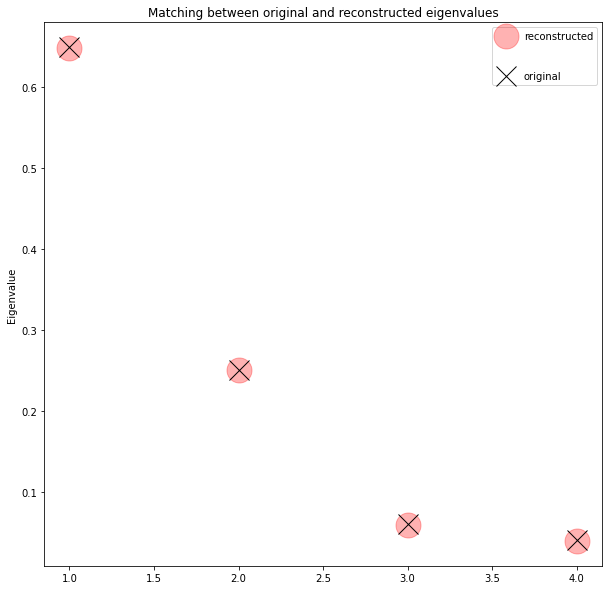

+-----------------+--------------------------+-------+
| True eigenvalue | Reconstructed eigenvalue | error |
+=================+==========================+=======+
| 0.650           | 0.648                    | 0.002 |
+-----------------+--------------------------+-------+
| 0.250           | 0.250                    | 0     |
+-----------------+--------------------------+-------+
| 0.060           | 0.059                    | 0.001 |
+-----------------+--------------------------+-------+
| 0.040           | 0.039                    | 0.001 |
+-----------------+--------------------------+-------+


In [5]:
results=qpca.spectral_benchmarking(eigenvector_benchmarking=False,sign_benchmarking=False ,eigenvalues_benchmarching=True,print_distances=True,only_first_eigenvectors=False,
                                                        plot_delta=True,distance_type='l2',error_with_sign=True,hide_plot=False,print_error=True)

In this specific case, using 8 resolution qubit and 1000000 shots, we can see a good approximation error.

# Eigenvectors reconstruction error trend

Here, we show the eigenvector reconstruction error trend by performing the same procedure of the first experiment but with different and increasing number of shots and resolution qubits. You can choose to show or not all the plots using the hide_plot flag.

In [6]:
shots_numbers=[100,500,1500,10000,100000,500000,1000000]
resolutions=[5,8]
resolution_dictionary={}
resolution_dictionary_shots={}
for resolution in resolutions:
    error_list=[]
    delta_list=[]
    shots_dict={}
    qpca=QPCA().fit(input_matrix,resolution=resolution)
    print('\n')
    print('\033[1m'+'Resolution: ',resolution)
    print('\n')
    for s in shots_numbers:
        
        reconstructed_eigenvalues,reconstructed_eigenvectors=qpca.eigenvectors_reconstruction(n_shots=s,n_repetitions=1)
        results=qpca.spectral_benchmarking(eigenvector_benchmarking=True,sign_benchmarking=False ,eigenvalues_benchmarching=False,print_distances=True,only_first_eigenvectors=False,
                                                        plot_delta=True,distance_type='l2',error_with_sign=True,hide_plot=True,print_error=False)
        for e in results[0][0]:
            shots_dict.setdefault(e[0], []).append(s)
        error_list.append(results[0][0])
        delta_list.append(results[0][1])
    
    resolution_dictionary_shots.update({resolution:shots_dict})
    resolution_dictionary.update({resolution:error_list})



Resolution:  5




/Users/tommasofioravanti/Desktop/Intesa/Quantum/Esperimenti/QuPCA/QPCA/postprocessingUtilities/postprocessing.py:104: RuntimeWarning: invalid value encountered in divide
  scaled_statevectors.append(statevector[i:i+len_input_matrix]/max_list[e])




Resolution:  8




Once you have computed all the errors for all the different cases, you can use the following function (in the following section) to have a better view of all the error trends. Remember to save always all the results relative to the different executions, using different combination of shots and resolution, in a dictionary, as we have done in the previous cell.

# A better view of the error trend

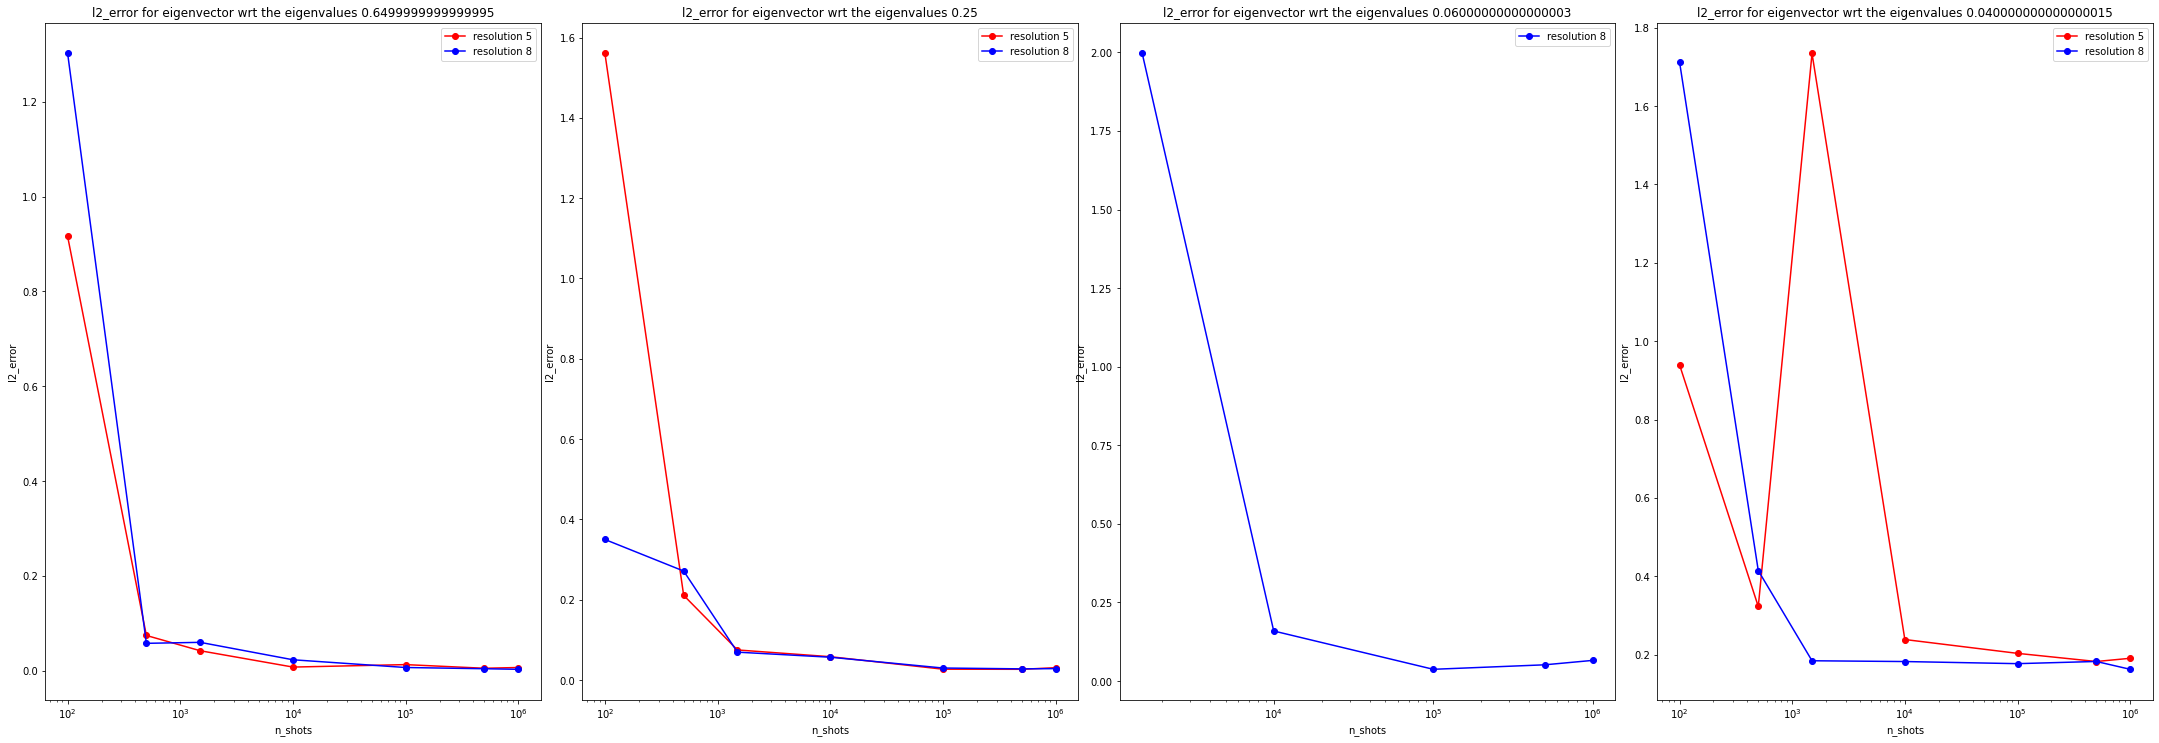

In [7]:
Benchmark_Manager.error_benchmark(input_matrix=input_matrix, shots_dict=resolution_dictionary_shots, error_dict=resolution_dictionary)

Here, we can notice that with the smaller resolution (3), we are able to reconstruct only the first two eigenvalues (and therefore eigenvectors) and for these two first eigenvectors, the errors are generally above all the other cases, considering a consistent number of shots. Then, we can see that with 8 resolution qubits, we are able to reconstruct all the four eigenvalues/eigenvectors and the corresponding error, for a consistent number of shots (e.g, 10^4 shots), is always lower than the others.

Generally, as expected, we can observe a decreases of the reconstruction error when the number of shots increases.